# Likert-Clusters v1.0
## A notebook for cluster analysis and visualization of survey data in likert scale

This notebook applies K-means algorithm for likert data (questionaries with answers betwen 1 to 5) and provides functions to visualize the emerging clusters in various ways.

Finland's parliamentary election data from 2015 is used as an example, but this notebook is designed to be easily used with another dataset.

### About data
- Data source: https://yle.fi/uutiset/3-7869597 (in finnish)
- License: [CC BY-SA 1.0](https://creativecommons.org/licenses/by-sa/1.0/legalcode)
([license in human readable form](https://creativecommons.org/licenses/by-sa/1.0/))

### About cluster analysis

The assumption this notebook makes is that if you get a bunch of answers then most of your participants tend to respond in ways that fall into several similar groupings (clusters), and this alone tells you something about the target population's conceptions regarding your questions.

There are a number of methods designed for visualizing likert data (e.g. item response theory, categorical data analyses, multidimensional nonlinear descriptive analysis, fuzzy probability & statistics, and dissimilarity/similarity analyses which require strong knowledge in statistics). Luckily, by using fairly simple distance measures and cluster algorithms you can compare individual responses for each participant to better understand whether their answers are all over the place or tend to fall into groups (the latter is the preferred result). 

### Using this notebook with custom data

Your input data should be pre-processed to a csv file of following format, e.g: 

| id | group1    | group2    | question1 | question2 | question3 |
|----|-----------|-----------|-----------|-----------|-----------|
| 1  | 1         | 1         | 3         | 4         | 4         |
| 2  | 1         | 5         | 5         | 5         | 2         |
| 3  | 0         | 7         | 1         | 3         | 4         |

Header row and id column can be arbitrary and do not show in plots but are expected to be included in the data. Question cells should have values between 1-5. Groups are features/clusters created in the preprocess phase and they should be between id and question columns.

To use this notebook on different data:
1. Preprocess your data into suitable format (see data directory for examples).
2. Configure settings section (the filename, file_delimiter and which column the likert data starts).
3. Set the question names as a list, and if needed any other data such as plain text meanings of groups' values for purposes of showing them in plots.
4. Read group columns as label variables in the section below if you want to use them in plots as clusters.
5. Run each cell.

## 1. Settings

In [ ]:
# the data file
filename = "data/yle-election-2015-clean.csv"
file_delimiter = ";"

# column number (starting from 0) from which likert data columns start
likert_data_cols_start = 8

In [2]:
questions = ['Suomessa on liian helppo elää sosiaaliturvan varassa',
    'Kaupan ja muiden liikkeiden aukioloajat on vapautettava',
    'Suomessa on siirryttävä perustuloon joka korvaisi nykyisen sosiaaliturvan vähimmäistason',
    'Työntekijälle on turvattava lailla minimityöaika',
    'Ansiosidonnaisen työttömyysturvan kestoa pitää lyhentää',
    'Euron ulkopuolella Suomi pärjäisi paremmin',
    'Ruoan verotusta on varaa kiristää',
    'Valtion ja kuntien taloutta on tasapainotettava ensisijaisesti leikkaamalla menoja',
    'Lapsilisiä on korotettava ja laitettava verolle',
    'Suomella ei ole varaa nykyisen laajuisiin sosiaali- ja terveyspalveluihin',
    'Nato-jäsenyys vahvistaisi Suomen turvallisuuspoliittista asemaa',
    'Suomeen tarvitaan enemmän poliiseja',
    'Maahanmuuttoa Suomeen on rajoitettava terrorismin uhan vuoksi',
    'Venäjän etupiiripolitiikka on uhka Suomelle',
    'Verkkovalvonnassa valtion turvallisuus on tärkeämpää kuin kansalaisten yksityisyyden suoja',
    'Suomen on osallistuttava Isisin vastaiseen taisteluun kouluttamalla Irakin hallituksen joukkoja',
    'Parantumattomasti sairaalla on oltava oikeus avustettuun kuolemaan',
    'Terveys- ja sosiaalipalvelut on tuotettava ensijaisesti julkisina palveluina',
    'Viranomaisten pitää puuttua lapsiperheiden ongelmiin nykyistä herkemmin',
    'Vanhuksen ja hänen omaistensa vastuuta hoitokustannuksista on lisättävä',
    'Kansalaisten oikeus terveyspalveluihin on tärkeämpää kuin kuntien itsehallinto',
    'Ilmastonmuutoksen hillitseminen pitää asettaa teollisuuden kilpailukyvyn edelle',
    'Geenimuunneltu ruoka on turvallista ihmiselle ja ympäristölle',
    'Suomen pitää ottaa suurempi vastuu EU:n alueelle tulevista turvapaikanhakijoista',
    'On aika luopua ajatuksesta, että koko Suomi on pidettävä asuttuna',
    'Peruskoulun opetusryhmien koko on rajattava lailla esimerkiksi 20 oppilaaseen']

electoral_districts = {
    'Ahvenanmaan maakunnan vaalipiiri': '05',
    'Helsingin vaalipiiri': '01',
    'Hämeen vaalipiiri': '06',
    'Kaakkois-Suomen vaalipiiri': '08',
    'Keski-Suomen vaalipiiri': '11',
    'Lapin vaalipiiri': '13',
    'Oulun vaalipiiri': '12',
    'Pirkanmaan vaalipiiri': '07',
    'Satakunnan vaalipiiri': '04',
    'Savo-Karjalan vaalipiiri': '09',
    'Uudenmaan vaalipiiri': '02',
    'Vaasan vaalipiiri': '10',
    'Varsinais-Suomen vaalipiiri': '03'
}

political_parties = {
    'Itsenäisyyspuolue': '4',
    'Kansallinen Kokoomus': '9',
    'Muut': '0',
    'Perussuomalaiset': '5',
    'Suomen Keskusta': '7',
    'Suomen Kristillisdemokraatit (KD)': '6',
    'Suomen Sosialidemokraattinen Puolue': '2',
    'Suomen ruotsalainen kansanpuolue': '8',
    'Vasemmistoliitto': '1',
    'Vihreä liitto': '3'
}

likert_scale = {
    'täysin eri mieltä': '1',
    'jokseenkin eri mieltä': '2',
    'ohita kysymys': '3',
    'jokseenkin samaa mieltä': '4',
    'täysin samaa mieltä': '5'
}

### Reading data

In [3]:
# necessary imports

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

%matplotlib inline

In [4]:
# read data from file and treat missing values
df = pd.read_csv(filename, delimiter=file_delimiter, encoding="utf8")

# prepare data as numpy arrays, assume that first columns hav an row id and groups as integers
groups = np.array(df.values[1:,1:likert_data_cols_start], dtype=int) 
data = np.array(df.values[1:,likert_data_cols_start:], dtype=int)

# prepare row and col counts for easy use
_, groups = groups.shape
rows, cols = data.shape

print("Data has", rows, "samples with", cols, "features and", groups, "predefined clusters.")

Data has 1837 samples with 26 features and 7 predefined clusters.


### Read pre-processed clusters

In [5]:
# prepare the labels for pre-processed "clusters"

# electoral districts "01"-"13"
label_districts = np.array(df.values[1:,0], dtype=int)
# main political parties = 0-9, 0 = rest of the parties
label_party = np.array(df.values[1:,1], dtype=int)

# 1 = man, 0 = woman
label_gender = np.array(df.values[1:,3], dtype=int)
# 1 = currently member of parliament, 0 not a member of parliament
label_is_mp = np.array(df.values[1:,4], dtype=int)
# 1 = was chosen to be mp in the election, 0 = was not chosen
label_was_chosen = np.array(df.values[1:,5], dtype=int)
# 1 = university degree, 0 = no university degree
label_education = np.array(df.values[1:,6], dtype=int)
# 1 = income over 70 000 euros per year, 0 = income less than 70k per year
label_income = np.array(df.values[1:,7], dtype=int)

## 2. Clustering

K-Means clustering separates the data into two clusters into given number of clusters. (Currently only clustering to two clusters is supported by notebook's visualization functions.)

The algorithm produces "cluster centers" in the likert data space, e.g.:

- Cluster A: "2 3 2 2 2 3 3 3 2 3 2 4 3"

- Cluster B: "4 4 3 2 3 2 4 4 4 4 4 4 2"

Also, each sample is labeled into either cluster A or B (internally stored as either 0 or 1), e.g:

- Labels: "0 1 0 0 0 1 1 1 1 0 1 0"

### Hierarchical clustering for preview

K-means expects the number of clusters to find as a parameter. Hierarchical clustering does not have this requirement of pre-determined number of clusters and we can use it as a help to decide how many clusters we want to look for.

In [9]:
from scipy.cluster.hierarchy import dendrogram, linkage
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html

def plot_hierarchical_clusters(data):
    Z1 = linkage(data, method='average', metric='euclidean')
    Z2 = linkage(data, method='complete', metric='cityblock')

    fig = plt.figure(figsize=(14,6))

    ax1 = plt.subplot(1,2,1)    
    dendrogram(Z1)
    ax1.set_xticks([])

    plt.title("method=average, metric=euclidic")

    ax2 = plt.subplot(1,2,2)
    dendrogram(Z2)
    ax2.set_xticks([])

    plt.title("method=complete, metric=cityblock")

    plt.show()


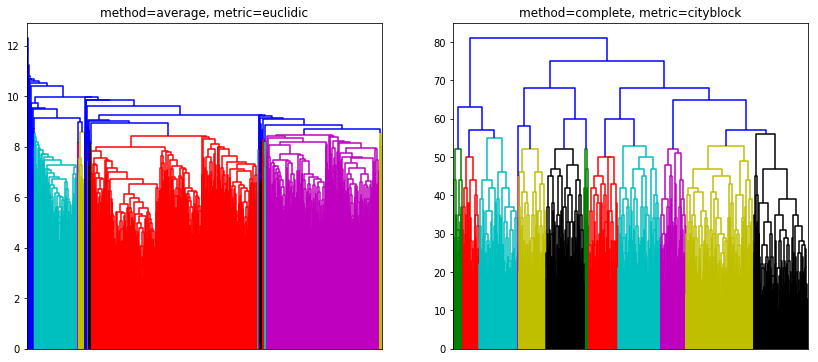

In [10]:
plot_hierarchical_clusters(data)

### Creating clusters with K-Means

In [13]:
from sklearn.cluster import KMeans

#from sklearn.cluster import AgglomerativeClustering
#ac = AgglomerativeClustering(n_clusters=2).fit(data)

def apply_kmeans(data):
    k = KMeans(n_clusters=2).fit(data)

    # index of the cluster each sample belongs to
    labels = k.labels_
    cluster_centers = np.round(k.cluster_centers_).astype(int)

    print("For", len(data), "samples...")
    print()
    print(cluster_centers, " are the cluster centers, and")
    print()
    print(labels, " are the labels for each sample.")
    
    return labels, cluster_centers

In [14]:
labels, cluster_centers = apply_kmeans(data)

For 1837 samples...

[[2 3 4 4 2 3 1 2 3 2 2 4 2 3 2 2 4 5 4 2 4 4 2 3 2 4]
 [3 4 3 3 3 3 1 4 2 3 3 4 3 4 3 3 3 3 4 2 4 3 2 2 2 3]]  are the cluster centers, and

[1 0 0 ... 1 1 1]  are the labels for each sample.


## 3. Visualizing answers between clusters

In [20]:
from math import ceil
from textwrap import wrap

def plot_answers(data, cluster_labels, cols_to_visualize, questions, answer_options=None, y_limit=1000):

    if type(cols_to_visualize) is tuple:
        cols_to_visualize = [x for x in range(*cols_to_visualize)]
    
    width = 2
    fig = plt.figure(figsize=(12, 24))
    fig.subplots_adjust(hspace=.5, top=1.85)

    for i in cols_to_visualize:
        ax = fig.add_subplot(ceil(cols/width), width, i+1)
        #ax.set_yticks([0,4,8,12])
        ind = np.arange(1,6)
        ax.set_xticks(ind + 0.5)
        ax.set_xticklabels(ind)

        axes = plt.gca()
        axes.set_ylim([0,y_limit])
        axes.set_xlim([1,6])

        title = "\n".join(wrap("{}. {}".format(i+1, questions[i]), 42))
        plt.title(title)
        ax.yaxis.grid() 

        histdata = [data[cluster_labels == 0,i], data[cluster_labels == 1,i]]
        patches = plt.hist(histdata, color=['orange', 'green'], bins=[1,2,3,4,5,6], stacked=True, 
            histtype='bar', label=['Cluster A', 'Cluster B'])

        if answer_options is None:
            answerA, answerB = None, None
        elif len(answer_options) == len(data):
            answerA, answerB = answer_options[i]  
        elif len(answer_options) == 2:
            answerA, answerB = answer_options[0], answer_options[1]        
        
        if answerA is not None:
            answerA = "\n".join(wrap(answerA, 26))
            answerB = "\n".join(wrap(answerB, 26))

        ax.text(0.02, -0.12, answerA,
            verticalalignment='top', horizontalalignment='left',
            transform=ax.transAxes, fontsize=10)
        ax.text(0.98, -0.12, answerB,
            verticalalignment='top', horizontalalignment='right',
            transform=ax.transAxes, fontsize=10)

    plt.legend(bbox_to_anchor=(1.3, 0.5), loc='center')

    #plt.tight_layout()
    #plt.savefig('survey1.png', format='png', dpi=600, bbox_inches='tight')
    plt.show()


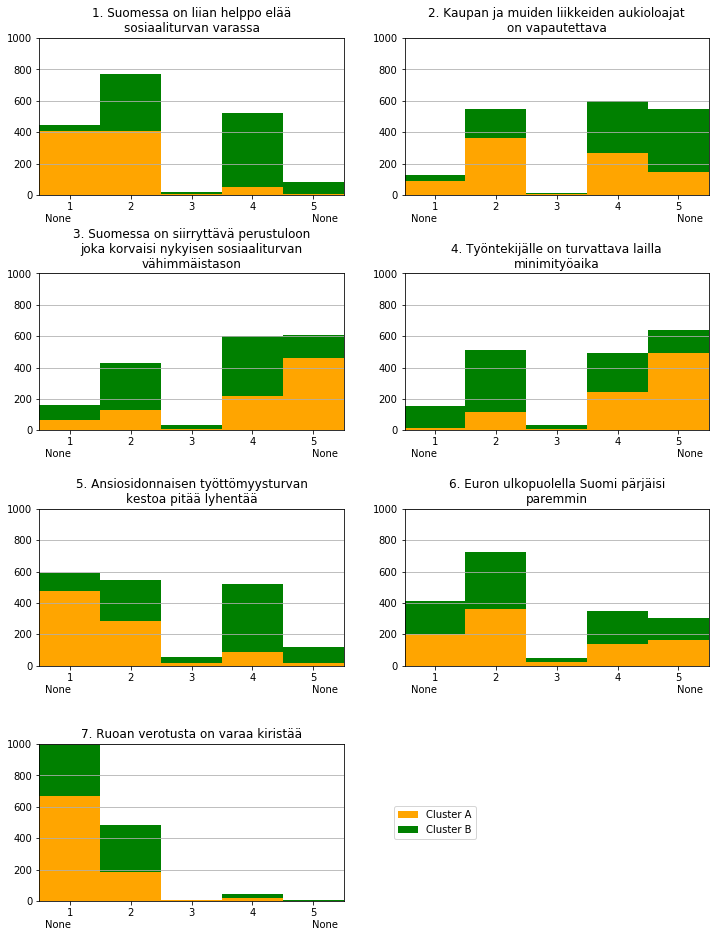

In [21]:
# plot the chosen questions and answers

plot_answers(data, labels, (0,7), questions)

## 4. Parallel coordinates

Parallel coordinates is another great way to visualize the data.

Samples are shown with dotted lines and cluster centers with normal lines.

In [22]:
from pandas.plotting import parallel_coordinates
import matplotlib.lines as mlines

def plot_parallel(data, cluster_labels, columns=(), cluster_centers=None, questions=None):

    #plt.close()

    rows, cols = data.shape
    if columns is ():
        col_from, col_to = 0, cols
    else:
        col_from, col_to = columns

    plt.figure(figsize=(12,6))

    # plot answers
    df_answers = pd.DataFrame(data[:,col_from:col_to])
    df_answers = df_answers.assign(Group=cluster_labels)
    axes = parallel_coordinates(df_answers, 'Group', alpha=0.05, linewidth=2.0, linestyle=':', color=('gold', 'lightgreen'))

    # plot cluster centers
    if cluster_centers is not None:
        df_clusters = pd.DataFrame(cluster_centers[:,col_from:col_to])
        centers = np.array([0,1], dtype=int)
        df_clusters = df_clusters.assign(Clusters=centers)
        axes = parallel_coordinates(df_clusters, 'Clusters', alpha=0.9, linewidth=4.0, color=('orange', 'green'))

    # create legend
    c1 = mlines.Line2D([], [], color='orange', linestyle=':', alpha=0.5, label='Cluster A answers')
    c2 = mlines.Line2D([], [], color='green', linestyle=':', alpha=0.5, label='Cluster B answer')
        
    if cluster_centers is not None:
        c3 = mlines.Line2D([], [], color='orange', linewidth=2.0, alpha=0.95, label='Cluster center A')
        c4 = mlines.Line2D([], [], color='green', linewidth=2.0, alpha=0.95, label='Cluster center B')
        
    if cluster_centers is not None:
        plt.legend(handles=[c1,c2,c3,c4], fontsize=10)
    else:
        plt.legend(handles=[c1,c2], fontsize=10)
    
    #plt.title('Parallel coordinates for questions and answers')
    num_questions = col_to - col_from
    plt.xlabel("{} questions".format(num_questions))
    plt.ylabel('Answers on scale from 1 to 5')
    
    axes.set_ylim([1,5])
    plt.yticks([1,2,3,4,5])
    col_names = [str(i) for i in range(col_from+1, col_to+1)]
    plt.xticks(range(0, len(col_names)), col_names)

    plt.show()
    if questions is not None:
        for idx, question in enumerate(questions[col_from:col_to]):
            print("{}. {}".format(col_from+idx+1, question))


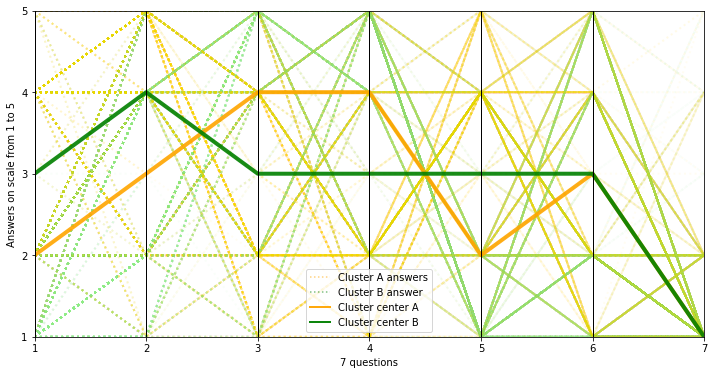

1. Suomessa on liian helppo elää sosiaaliturvan varassa
2. Kaupan ja muiden liikkeiden aukioloajat on vapautettava
3. Suomessa on siirryttävä perustuloon joka korvaisi nykyisen sosiaaliturvan vähimmäistason
4. Työntekijälle on turvattava lailla minimityöaika
5. Ansiosidonnaisen työttömyysturvan kestoa pitää lyhentää
6. Euron ulkopuolella Suomi pärjäisi paremmin
7. Ruoan verotusta on varaa kiristää


In [29]:
# visualize parallel coordinates

plot_parallel(data, labels, columns=(0,7), cluster_centers=cluster_centers, questions=questions)
#plot_parallel(data, labels)


## 5. Visualizing with PCA, MDS and t-SNE

Three methods are used here to reduce the dimensions to 2D for visualizing. Unfortunately reducing dimensions to two always loses some data. 

Each method tries to preserve some aspect: PCA preserves variance, MDS preserves distances and t-SNE preserves topology.

In [24]:
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.manifold import TSNE

def normalize_likert(data):
    # (1,5) to (-1,1)
    return (data - 3) / 2.0

def run_pca(data):

    # apply PCA
    pca = PCA(n_components=2)
    x_pca = pca.fit_transform(data)
    print(pca.explained_variance_ratio_)
    return x_pca

def run_mds(data):

    # apply MDS
    mds = MDS(n_components=2)
    x_mds = mds.fit_transform(data)

    return x_mds
    
def run_tsne(data):
    
    # apply t-SNE
    tsne = TSNE(n_components=2, perplexity=5.0)
    x_tsne = tsne.fit_transform(data)
    
    return x_tsne


In [25]:
# plot all three methods

def plot_clusters(xpca, xmds, xtsne, labels):
    """ Plots PCA, MDS T-sne clusters with colored labels. """

    fig = plt.figure(1, figsize=(18,6))
    #fig.suptitle("Cluster visualization", fontsize=12)
    fig.subplots_adjust(top=0.85)

    ax = plt.subplot(1,3,1)
    ax.set_xticks([])
    ax.set_yticks([])

    plt.scatter(xpca[:,0], xpca[:,1], s=50, alpha=0.5, c=labels, cmap=plt.cm.get_cmap('plasma'))
    plt.title("Principal Component Analysis")

    ax = plt.subplot(1,3,2)
    ax.set_xticks([])
    ax.set_yticks([])

    plt.title("Multi-Dimensional Scaling")
    plt.scatter(xmds[:,0], xmds[:,1], s=50, alpha=0.5, c=labels, cmap=plt.cm.get_cmap('plasma'))

    ax = plt.subplot(1,3,3)
    ax.set_xticks([])
    ax.set_yticks([])

    plt.title("t-SNE")
    plt.scatter(xtsne[:,0], xtsne[:,1], s=50, alpha=0.5, c=labels, cmap=plt.cm.get_cmap('plasma'))

    plt.show()


In [26]:
# run algorithms to reduce dimensions to 2D
normalized = normalize_likert(data)
x_pca = run_pca(normalized)
x_mds = run_mds(normalized)
x_tsne = run_tsne(normalized)


[0.23391993 0.13011231]


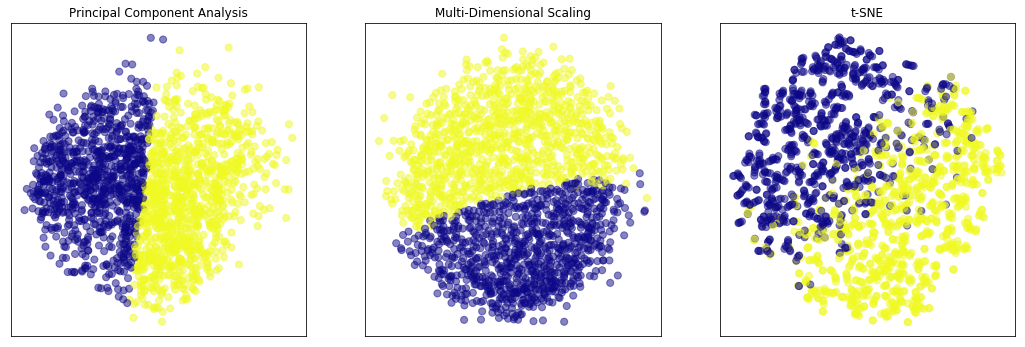

In [27]:
# visualise clusters
labels = labels
plot_clusters(x_pca, x_mds, x_tsne, labels)